# Neural Networks - Project

# Predictive Modeling

### 1. Data import and Understanding [10 Marks]

#### 1A. Read the ‘Signals.csv’ as DataFrame and import required libraries. [2 Marks]

In [1]:
#Importing all the necessary libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn import preprocessing 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, losses, Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Input, InputLayer, Reshape
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from keras.wrappers.scikit_learn import KerasClassifier

import h5py

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Reading the Signal.csv file
sig = pd.read_csv('/content/drive/MyDrive/Python - Collab/11. Module-8_Intro to Neural Networks & Deep Learning/Neural Networks - Project/Signal.csv')
sig.head()

,Parameter 1,Parameter 2,Parameter 3,Parameter 4,Parameter 5,Parameter 6,Parameter 7,Parameter 8,Parameter 9,Parameter 10,Parameter 11,Signal_Strength
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


#### 1B. Check for missing values and print percentage for each attribute. [2 Marks]

In [3]:
#checking for Null/Missing Values
sig_null = pd.DataFrame({'Null_Values': sig.isnull().sum(), 'Null_Value(%)': sig.isnull().sum()*100})
sig_null

,Null_Values,Null_Value(%)
Parameter 1,0,0
Parameter 2,0,0
Parameter 3,0,0
Parameter 4,0,0
Parameter 5,0,0
Parameter 6,0,0
Parameter 7,0,0
Parameter 8,0,0
Parameter 9,0,0
Parameter 10,0,0


This suggests that there seems to be no null values/missing values present in the dataset.

#### 1C. Check for presence of duplicate records in the dataset and impute with appropriate method. [2 Marks]

In [4]:
#Checking for presence of duplicate records
sig_dup = sig.duplicated()
sum(sig_dup)

240

In [5]:
#Dropping all the duplicated rows
sig = sig.drop_duplicates(keep='first', ignore_index=True)

#### 1D. Visualise distribution of the target variable. [2 Marks]

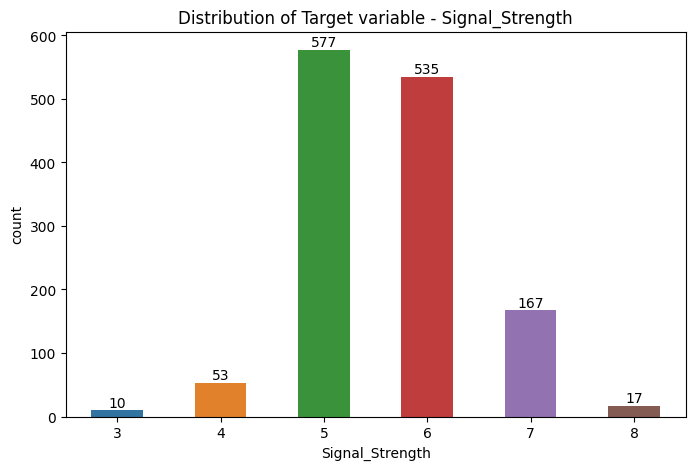

In [6]:
#Visualizing the distribution of target variable - 'Signal_Strength'
plt.figure(figsize=(8,5))
sns.countplot(sig, x=sig['Signal_Strength'], width=0.5)
plt.xlabel('Signal_Strength')
for i in range(len(sig['Signal_Strength'].value_counts())):
  plt.text(i, sig['Signal_Strength'].value_counts()[i+3]+5, sig['Signal_Strength'].value_counts()[i+3], ha='center')
plt.title('Distribution of Target variable - Signal_Strength')
plt.show();

- From the above distrubution graph, it seems that majority of the signal have strength of 5 or 6 (~ 82%)
- Signal Strength of 3 or 8 are very much less compared to that of other signal strength (~2%).

#### 1E.  Share insights from the initial data analysis (at least 2). [2 Marks]

##### Insights
- As already mentioned, the data has no missing values. Further the duplicate values found were dropped from the dataset.
- The Signal Strength ranges from 3(lowest) to 8(highest).
- Further the data has clean values, i.e. all the parameters are float type while the target feature is int type.

### 2. Data preprocessing [7 Marks]

#### 2A. Split the data into X & Y. [1 Marks]

In [7]:
#Splitting the data set into feature variable(x) & target variable(y)
x = sig.drop('Signal_Strength', axis=1)
y = sig['Signal_Strength']

#### 2B. Split the data into train & test with 70:30 proportion.[1 Marks]

In [8]:
#Splitting the data set into train & test set
x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.3, random_state=1, stratify=y)

#### 2C. Print shape of all the 4 variables and verify if train and test data is in sync. [1 Marks]

In [9]:
#Printing the shape of all the 4 variables
print('Training Datasets')
print('Shape of X-Train:', x_tr.shape)
print('Shape of Y-Train:', y_tr.shape, '\n')
print('Testing Dataset')
print('Shape of X-Test:', x_te.shape)
print('Shape of Y-Test:', y_te.shape)

Training Datasets
Shape of X-Train: (951, 11)
Shape of Y-Train: (951,) 

Testing Dataset
Shape of X-Test: (408, 11)
Shape of Y-Test: (408,)


In [10]:
#Verifying the train & test data to be in sync
data_sync = pd.DataFrame({'Original Data(Ratio)': round(sig['Signal_Strength'].value_counts(normalize=True),3), 'Training Set':round(y_tr.value_counts(normalize=True),3), 'Testing Set':round(y_te.value_counts(normalize=True),3)})
data_sync.reset_index().sort_values(by='index', ascending=True).rename(columns={'index':'Signal_Strength'}).set_index('Signal_Strength')

,Original Data(Ratio),Training Set,Testing Set
Signal_Strength,,,
3,0.007,0.007,0.007
4,0.039,0.039,0.039
5,0.425,0.425,0.424
6,0.394,0.393,0.395
7,0.123,0.123,0.123
8,0.013,0.013,0.012


- Since the distribution of of target variable is imbalanced as visualized in the graph, we have already stratified 'y' during the splitting of train & test data.
- Hence from the above dataframe it is visible that the ratio of all the values in target column in the original dataset is maintained in Training set as well as Testing set.
- Hence on this basis we can say that the data of train & test is in sync.

#### 2D. Normalise the train and test data with appropriate method. [2 Marks]

In [11]:
#Normaizing the training & testing data
x_tr = preprocessing.scale(x_tr)
x_te = preprocessing.scale(x_te)

#### 2E. Transform Labels into format acceptable by Neural Network [2 Marks]

In [12]:
# Encoding the Target variable
le = preprocessing.LabelEncoder()
y_tr = le.fit_transform(y_tr)
y_te = le.fit_transform(y_te)

- Since our Target features have values ranging from 3 to 8, we need to convert them into range starting from 0 which is acceptable by neural network.
- We can use the range from 0 to 8 as well by transforming the labels to categorical format but it will only generate a vector having first 3 columns as 0 (Columns 0, 1, & 2) as we have values starting from 3.
- Further instead of generating the vector, we can use the Sparse Categorical Cross Entropy as our data is already numerical & hence we need not convert it to categorical vector with 0 & 1 value.
- Using Sparse Categorical Cross Entropy is faster compared to Categorical Cross Entropy as we deal directly with number instead of the whole vector.

### 3. Model Training & Evaluation using Neural Network [13 Marks]

#### 3A. Design a Neural Network to train a classifier. [3 Marks]

In [13]:
#Designing a Neural Network model(Basic Model)
sig1 = Sequential()
sig1.add(InputLayer(input_shape=(x_tr.shape[1],)))
sig1.add(Dense(2, activation='relu'))
sig1.add(Dense(6, activation='softmax'))

#Compiling the Model
sig1.compile(loss=losses.sparse_categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

In [14]:
sig1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 24        
                                                                 
 dense_1 (Dense)             (None, 6)                 18        
                                                                 
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


#### 3B. Train the classifier using previously designed Architecture [2 Mark]

In [15]:
#Fitting the Model
SIG1 = sig1.fit(x_tr, y_tr, epochs=10, verbose=1, validation_data=(x_te, y_te))

Epoch 1/10
30/30 [==============================] - 5s 10ms/step - loss: 2.0369 - accuracy: 0.2986 - val_loss: 2.0157 - val_accuracy: 0.2868
Epoch 2/10
30/30 [==============================] - 0s 4ms/step - loss: 1.9534 - accuracy: 0.3260 - val_loss: 1.9356 - val_accuracy: 0.3137
Epoch 3/10
30/30 [==============================] - 0s 5ms/step - loss: 1.8820 - accuracy: 0.3491 - val_loss: 1.8689 - val_accuracy: 0.3333
Epoch 4/10
30/30 [==============================] - 0s 4ms/step - loss: 1.8228 - accuracy: 0.3628 - val_loss: 1.8102 - val_accuracy: 0.3603
Epoch 5/10
30/30 [==============================] - 0s 5ms/step - loss: 1.7713 - accuracy: 0.3828 - val_loss: 1.7614 - val_accuracy: 0.3627
Epoch 6/10
30/30 [==============================] - 0s 5ms/step - loss: 1.7270 - accuracy: 0.3933 - val_loss: 1.7195 - val_accuracy: 0.3725
Epoch 7/10
30/30 [==============================] - 0s 4ms/step - loss: 1.6885 - accuracy: 0.4038 - val_loss: 1.6822 - val_accuracy: 0.3848
Epoch 8/10
30/30 [=

In [16]:
loss1, accuracy1 = sig1.evaluate(x_te, y_te, verbose=1)
print('The accuracy of the model is:', accuracy1)

13/13 [==============================] - 0s 3ms/step - loss: 1.5913 - accuracy: 0.4118
The accuracy of the model is: 0.4117647111415863


#### 3C. Plot 2 separate visuals. [3 Marks]

#### 3C(i). Training Loss and Validation Loss

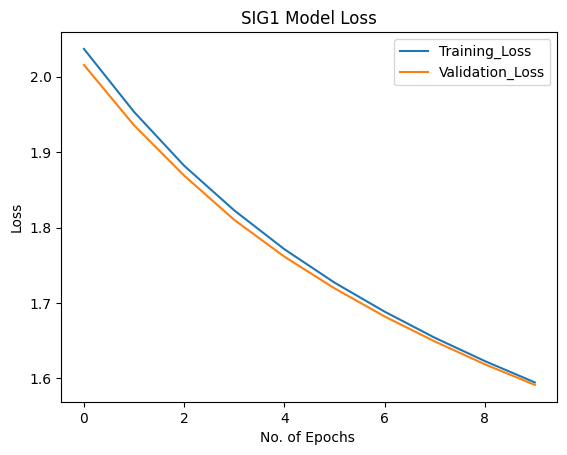

In [17]:
#Visualizing the Training loss & Validation loss of the above model
plt.plot(SIG1.history['loss'])
plt.plot(SIG1.history['val_loss'])
plt.title('SIG1 Model Loss')
plt.xlabel('No. of Epochs ')
plt.ylabel('Loss')
plt.legend(['Training_Loss', 'Validation_Loss'], loc='best')
plt.show();

#### 3C(ii). Training Accuracy and Validation Accuracy

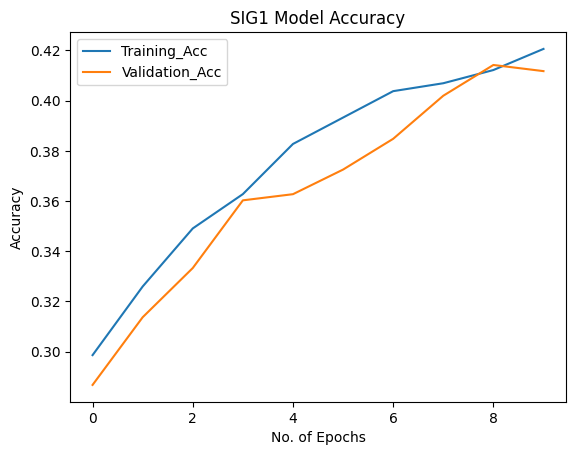

In [18]:
#Visualizing the Training Accuracy & Validation Accuracy of the above model
plt.plot(SIG1.history['accuracy'])
plt.plot(SIG1.history['val_accuracy'])
plt.title('SIG1 Model Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training_Acc', 'Validation_Acc'], loc='best')
plt.show();

#### 3D. Design new architecture/update existing architecture in attempt to improve the performance of the model. [2 Marks]

In [19]:
#Designing New Model

#Creating the new model 
sign = Sequential()
sign.add(InputLayer(input_shape=(x_tr.shape[1],)))
sign.add(BatchNormalization())
sign.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
sign.add(BatchNormalization())
sign.add(Dropout(0.5))
sign.add(Dense(64, activation='tanh', kernel_initializer='he_uniform'))
sign.add(BatchNormalization())
sign.add(Dropout(0.5))
sign.add(Dense(64, activation='tanh', kernel_initializer='he_uniform'))
sign.add(BatchNormalization())
sign.add(Dense(6, activation='softmax'))

#Compiling the model
sign.compile(loss=losses.sparse_categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

In [20]:
sign.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 11)               44        
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 128)               1536      
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_2 (Batc  (None, 64)              

In [21]:
#Fittig the model
SIGN = sign.fit(x_tr, y_tr, epochs=100, verbose=2, validation_data=(x_te, y_te), batch_size=128)

Epoch 1/100
8/8 - 4s - loss: 2.3748 - accuracy: 0.1924 - val_loss: 2.1296 - val_accuracy: 0.1225 - 4s/epoch - 453ms/step
Epoch 2/100
8/8 - 0s - loss: 2.1250 - accuracy: 0.2366 - val_loss: 1.8833 - val_accuracy: 0.2426 - 74ms/epoch - 9ms/step
Epoch 3/100
8/8 - 0s - loss: 1.9069 - accuracy: 0.2934 - val_loss: 1.7050 - val_accuracy: 0.3382 - 70ms/epoch - 9ms/step
Epoch 4/100
8/8 - 0s - loss: 1.7526 - accuracy: 0.3722 - val_loss: 1.5917 - val_accuracy: 0.3897 - 76ms/epoch - 10ms/step
Epoch 5/100
8/8 - 0s - loss: 1.7248 - accuracy: 0.3807 - val_loss: 1.5190 - val_accuracy: 0.4485 - 72ms/epoch - 9ms/step
Epoch 6/100
8/8 - 0s - loss: 1.6129 - accuracy: 0.4069 - val_loss: 1.4642 - val_accuracy: 0.4877 - 78ms/epoch - 10ms/step
Epoch 7/100
8/8 - 0s - loss: 1.6014 - accuracy: 0.4395 - val_loss: 1.4258 - val_accuracy: 0.5123 - 70ms/epoch - 9ms/step
Epoch 8/100
8/8 - 0s - loss: 1.4939 - accuracy: 0.4595 - val_loss: 1.3934 - val_accuracy: 0.5343 - 71ms/epoch - 9ms/step
Epoch 9/100
8/8 - 0s - loss: 1

In [22]:
loss_sign, accuracy_sign = sign.evaluate(x_te, y_te, verbose=1)
print('The Accuracy of the updated model is:', accuracy_sign)

13/13 [==============================] - 0s 4ms/step - loss: 0.9565 - accuracy: 0.5735
The Accuracy of the updated model is: 0.5735294222831726


#### 3E. Plot visuals as in Q3.C and share insights about difference observed in both the models. [3 Marks]

##### Visualizing Training Loss vs Validation Loss of the above updated model

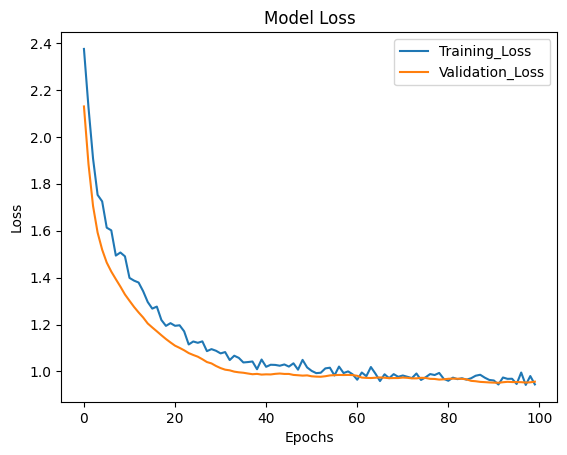

In [23]:
#Visualizing the Training loss & Validation loss of the updated model
plt.plot(SIGN.history['loss'])
plt.plot(SIGN.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training_Loss', 'Validation_Loss'], loc='best')
plt.show();

##### Visualizing Training Accuracy vs Validation Accuracy of the updated model.

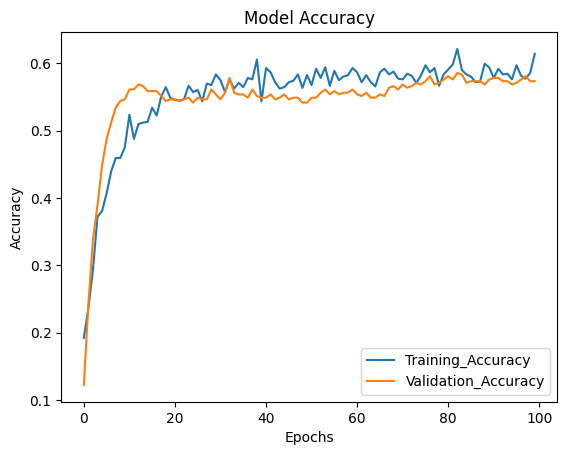

In [24]:
#Visualizing the Training accuracy & Validation accuracy of the updated model
plt.plot(SIGN.history['accuracy'])
plt.plot(SIGN.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training_Accuracy', 'Validation_Accuracy'], loc='best')
plt.show();

In [25]:
#Predicting the values
y_pred_sig1 = sig1.predict(x_te)
y_pred_sig1_fin = []
for i in y_pred_sig1:
  y_pred_sig1_fin.append(np.argmax(i))

y_pred_sign = sign.predict(x_te)
y_pred_sign_fin = []
for i in y_pred_sign:
  y_pred_sign_fin.append(np.argmax(i))

print('\n')
#Printing the Classification Report
print('Classification Report of Model1:\n', classification_report(y_te, y_pred_sig1_fin), '\n')
print('Classification Report of Updated Model:\n', classification_report(y_te, y_pred_sign_fin))

13/13 [==============================] - 0s 2ms/step


Classification Report of Model1:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00        16
           2       0.43      0.62      0.51       173
           3       0.40      0.38      0.39       161
           4       0.00      0.00      0.00        50
           5       0.00      0.00      0.00         5

    accuracy                           0.41       408
   macro avg       0.14      0.17      0.15       408
weighted avg       0.34      0.41      0.37       408
 

Classification Report of Updated Model:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.20      0.06      0.10        16
           2       0.65      0.76      0.70       173
           3       0.54      0.53      0.53       161
           4       0.38      0.32      0.35        50


In [26]:
#Comparing both the model
sig_comp = pd.DataFrame({'Model_Name':['Model1', 'Updated_Model'], 'Loss':[loss1, loss_sign], 'Accuracy':[accuracy1, accuracy_sign]})
sig_comp

,Model_Name,Loss,Accuracy
0,Model1,1.591322,0.411765
1,Updated_Model,0.956498,0.573529


#### Observations:
- Here we see that the accuracy of the model is not very much high.
- But on the contrary, the updated model has significant improvement over the previous model.
- Further the point to be noted is that the dataset is very small which doesnot help in training the model.
- Also the dataset is highly imbalanced which affects the performance of the model.
- Hence even though applying all the parameters, accuracy cannot be improved as the model cannot train on scarce data.